In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np

ratings = pd.read_csv('/content/drive/MyDrive/ratings.csv', sep='\t', encoding='latin-1',
                      usecols=['user_id', 'movie_id', 'user_emb_id', 'movie_emb_id', 'rating'])

movies = pd.read_csv('/content/drive/MyDrive/movies.csv', sep='\t', encoding='latin-1',
                     usecols=['movie_id', 'title', 'genres'])

In [ ]:
movies.head(5)

,movie_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [ ]:
ratings.head(5)

,user_id,movie_id,rating,user_emb_id,movie_emb_id
0,1,1193,5,0,1192
1,1,661,3,0,660
2,1,914,3,0,913
3,1,3408,4,0,3407
4,1,2355,5,0,2354


### Content Based

**Objective**: Build a Content-Based Recommendation system that computes similarity between movies based on movie genres. It will suggest movies that are most similar to a particular movie based on its genre.

**Dataset**:
- **Movies Data**: DataFrame with columns `movie_id`, `title`, and `genres`.

**Steps**:

1. **Preprocess Data**:
   - Split the `genres` column into separate genre strings.
   - Fill any missing values in the `genres` column and convert it to string.

2. **Compute TF-IDF Matrix**:
   - Use `TfidfVectorizer` to transform the genres into a TF-IDF matrix.

3. **Calculate Cosine Similarity**:
   - Compute cosine similarity between the TF-IDF matrices of movies.

4. **Recommend Movies**:
   - Create a function that gets movie recommendations based on the cosine similarity score of movie genres.

In [ ]:
movies['genres'] = movies['genres'].str.split('|')
movies['genres'] = movies['genres'].fillna("").astype('str')

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(movies['genres'])

In [ ]:
from sklearn.metrics.pairwise import linear_kernel

cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [ ]:
def genre_recommendations(title, n=10):
    idx = movies[movies['title'] == title].index[0]
    scores = cosine_sim[idx, :]
    args = np.argsort(scores)[::-1]
    indexes = args[:n + 1]
    for i in indexes:
      movie = movies.loc[i, 'title']
      if movie != title:
        print(movie)

In [ ]:
# Example
genre_recommendations('GoldenEye (1995)')

Daylight (1996)
Anaconda (1997)
Con Air (1997)
Maximum Risk (1996)
Firestorm (1998)
Rock, The (1996)
Chain Reaction (1996)
Clear and Present Danger (1994)
Surviving the Game (1994)
Perfect Storm, The (2000)



### Collaborative Filtering

**Objective**: Implement a collaborative filtering movie recommendation system to recommend movies to a user based on similar users' preferences.

**Dataset**:

- **Ratings Data**: DataFrame with columns `user_id`, `movie_id`, and `rating`.
- **Movies Data**: DataFrame with columns `movie_id`, `title`, and `genres`.

**Steps**:

1. **Preprocess Data**:
   - Merge `ratings` and `movies` DataFrames on `movie_id`.
   - Split `genres` column into separate rows.

2. **Create User-Genre Matrix**:
   - Create a matrix where rows are users and columns are genres.
   - Each cell represents the ratio of movies watched by the user in that genre to the total movies watched by the user.

3. **Calculate User Similarity**:
   - Use cosine similarity to calculate the similarity between users.

4. **Find Top N Similar Users**:
   - Find the top N users with the most similar preferences to the given user.

5. **Recommend Movies**:
   - Recommend movies that similar users have watched but the target user has not.
   - Return titles and genres of the top 10 recommended movies.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
data = pd.merge(ratings, movies, on='movie_id')

In [ ]:
data.head(5)

,user_id,movie_id,rating,user_emb_id,movie_emb_id,title,genres
0,1,1193,5,0,1192,One Flew Over the Cuckoo's Nest (1975),Drama
1,2,1193,5,1,1192,One Flew Over the Cuckoo's Nest (1975),Drama
2,12,1193,4,11,1192,One Flew Over the Cuckoo's Nest (1975),Drama
3,15,1193,4,14,1192,One Flew Over the Cuckoo's Nest (1975),Drama
4,17,1193,5,16,1192,One Flew Over the Cuckoo's Nest (1975),Drama


In [ ]:
data = data.assign(genres=data['genres'].str.split('|')).explode('genres')

In [ ]:
data.head(5)

,user_id,movie_id,rating,user_emb_id,movie_emb_id,title,genres
0,1,1193,5,0,1192,One Flew Over the Cuckoo's Nest (1975),Drama
1,2,1193,5,1,1192,One Flew Over the Cuckoo's Nest (1975),Drama
2,12,1193,4,11,1192,One Flew Over the Cuckoo's Nest (1975),Drama
3,15,1193,4,14,1192,One Flew Over the Cuckoo's Nest (1975),Drama
4,17,1193,5,16,1192,One Flew Over the Cuckoo's Nest (1975),Drama


In [ ]:
users = data['user_id'].unique()
genres = data['genres'].unique()
movie_ids = data['movie_id'].unique()

user_genres_mat = np.zeros((len(users), len(genres)))
user_movies_mat = np.zeros((len(users), len(movie_ids)))

In [ ]:
for user in users:
  watched_movies = data[data['user_id'] == user]
  num_watched_movies = len(watched_movies['movie_id'].unique())
  num_genres = watched_movies['genres'].value_counts()
  for genre, num in num_genres.items():
    user_genres_mat[np.argwhere(users == user)[0][0], np.argwhere(genres == genre)[0][0]] = num / num_watched_movies

In [ ]:
for user in users:
  watched_movies = data[data['user_id'] == user]
  for index, row in watched_movies.iterrows():
    target_movie = row['movie_id']
    target_rate = row['rating']
    user_movies_mat[np.argwhere(users == user)[0][0], np.argwhere(movie_ids == target_movie)[0][0]] = target_rate

In [ ]:
sim_mat = cosine_similarity(user_genres_mat, user_genres_mat)

In [ ]:
def get_top_n_similar_users(user_id, n=5):
    user_sim = sim_mat[np.argwhere(users == user_id)[0][0]]
    args = np.argsort(user_sim)[::-1]
    selected_args = args[:n+1]
    selected_users = []
    for arg in selected_args:
      if users[arg] != user_id:
        selected_users.append((users[arg], user_sim[arg]))
    return selected_users

In [ ]:
def recommend_movies(user_id, n_similar_users=5, n_recommendations=10):
  similar_users = get_top_n_similar_users(user_id, n_similar_users)
  watched_movies = data[data['user_id'] == user_id]['movie_id'].unique()
  selected_movies = []

  sum_movie_scores = np.zeros((user_movies_mat.shape[1]))
  sum_sims = 0
  for user_id, sim in similar_users:
    sum_movie_scores += user_movies_mat[np.argwhere(users == user_id)[0][0]] * sim
    sum_sims += sim
  avg_movie_scores = sum_movie_scores / sum_sims

  args = np.argsort(avg_movie_scores)[::-1]
  for idx in args:
    movie = movie_ids[idx]
    if movie not in watched_movies:
      selected_movies.append(movie)
    if len(selected_movies) == n_recommendations:
      break

  return movies.query('movie_id in @selected_movies')

In [ ]:
# Example
user_id = 1
recommended_movies = recommend_movies(user_id, n_similar_users=5, n_recommendations=10)

In [ ]:
recommended_movies

,movie_id,title,genres
259,262,"Little Princess, A (1995)",Children's|Drama
589,593,"Silence of the Lambs, The (1991)",Drama|Thriller
1019,1032,Alice in Wonderland (1951),Animation|Children's|Musical
1180,1198,Raiders of the Lost Ark (1981),Action|Adventure
1575,1617,L.A. Confidential (1997),Crime|Film-Noir|Mystery|Thriller
2009,2078,"Jungle Book, The (1967)",Animation|Children's|Comedy|Musical
2011,2080,Lady and the Tramp (1955),Animation|Children's|Comedy|Musical|Romance
2012,2081,"Little Mermaid, The (1989)",Animation|Children's|Comedy|Musical|Romance
2027,2096,Sleeping Beauty (1959),Animation|Children's|Musical
2789,2858,American Beauty (1999),Comedy|Drama


### SVD (Singular Value Decomposition)



**Objective**: Implement an SVD-based recommendation system to recommend movies to users by decomposing the user-item interaction matrix into latent factors.

**Dataset**:
- **Ratings Data**: DataFrame with columns `user_id`, `movie_id`, and `rating`.
- **Movies Data**: DataFrame with columns `movie_id`, `title`, and `genres`.

**Steps**:

1. **Preprocess Data**:
   - Merge `ratings` and `movies` DataFrames on `movie_id`.
   - Create a user-item matrix where rows represent users, columns represent movies, and the values are the ratings.

2. **Decompose Matrix using SVD**:
   - Apply Singular Value Decomposition (SVD) to decompose the user-item matrix into three matrices: $U$, $\Sigma$, and $V^T$.

3. **Reconstruct Matrix**:
   - Reconstruct the user-item matrix using the top $k$ singular values to reduce dimensionality.

4. **Predict Ratings**:
   - Use the reconstructed matrix to predict ratings for all user-item pairs.

5. **Recommend Movies**:
   - Recommend the top 20 movies with the highest predicted ratings for a given user that the user hasn't rated yet.

In [ ]:
n_users = ratings.user_id.unique().shape[0]
n_movies = ratings.movie_id.unique().shape[0]
print('Number of users = ' + str(n_users) + ' | Number of movies = ' + str(n_movies))

Number of users = 6040 | Number of movies = 3706


Fill na elements.

In [ ]:
Ratings = ratings.pivot(index = 'user_id', columns ='movie_id', values = 'rating').fillna(0)
Ratings.head()

movie_id,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
user_id,,,,,,,,,,,,,,,,,,,,,
1,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# calculate rating matrix
rating_mat = Ratings.to_numpy()

In [ ]:
U, sigma, Vt = np.linalg.svd(rating_mat, full_matrices=False)
sigma = np.diag(sigma)

In [ ]:
print(U.shape)
print(sigma.shape)
print(Vt.shape)

(6040, 3706)
(3706, 3706)
(3706, 3706)


In [ ]:
k = 50
U_k = U[:, :k]
sigma_k = sigma[:k, :k]
Vt_k = Vt[:k, :]
all_user_predicted_ratings = np.dot(np.dot(U_k, sigma_k), Vt_k)

In [ ]:
preds = pd.DataFrame(all_user_predicted_ratings, columns = Ratings.columns)
preds.head()

movie_id,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
0,4.292556,0.164772,-0.184504,-0.018528,0.021516,-0.181793,-0.102936,0.157111,-0.058523,-0.164231,...,0.032475,0.007048,0.033170,-0.007577,-0.075329,0.394578,0.124714,0.051545,0.057349,0.076743
1,0.754817,0.128981,0.341128,0.009540,0.001830,1.314580,0.077427,0.062218,0.163983,1.514572,...,-0.051376,-0.015780,-0.010918,0.055628,-0.016037,0.166941,-0.421144,-0.106675,-0.049650,-0.126564
2,1.844858,0.473855,0.098573,-0.039309,-0.019895,-0.154038,-0.141531,0.111551,0.035977,0.738427,...,0.049994,0.003596,0.022734,0.043377,0.034825,0.120205,0.086553,0.034783,0.029337,-0.121871
3,0.395484,-0.045487,0.033716,0.083890,0.051561,0.260676,-0.081541,0.023891,0.051932,-0.077170,...,0.010847,0.007518,0.004269,0.009527,-0.079630,0.077845,0.051369,-0.017046,0.018980,-0.047580
4,1.557609,-0.006700,-0.044860,0.249014,-0.043320,1.518140,-0.164306,-0.043626,-0.078771,0.424064,...,0.097708,0.013847,-0.024256,-0.043126,-0.065997,-0.025571,0.517685,0.008508,0.106630,0.221219


In [ ]:
def recommend_movies(predictions, userID, movies, original_ratings, num_recommendations):

    user_row_number = userID - 1 # User ID starts at 1, not 0
    sorted_user_predictions = predictions.iloc[user_row_number].sort_values(ascending=False)

    user_data = original_ratings[original_ratings.user_id == (userID)]

    # merfe movies data with user_data
    user_full = (user_data.merge(movies, how = 'left', left_on = 'movie_id', right_on = 'movie_id').sort_values(['rating'], ascending=False))


    print(f'User {userID} has already rated {user_full.shape[0]} movies.')
    print(f'Recommending highest {num_recommendations} predicted ratings movies not already rated.')

    recommendations = (movies[~movies['movie_id'].isin(user_full['movie_id'])])

    return user_full, recommendations

In [ ]:
already_rated, predictions = recommend_movies(preds, 4375, movies, ratings, 20)

User 4375 has already rated 325 movies.
Recommending highest 20 predicted ratings movies not already rated.


In [ ]:
ratings.head(20)

,user_id,movie_id,rating,user_emb_id,movie_emb_id
0,1,1193,5,0,1192
1,1,661,3,0,660
2,1,914,3,0,913
3,1,3408,4,0,3407
4,1,2355,5,0,2354
5,1,1197,3,0,1196
6,1,1287,5,0,1286
7,1,2804,5,0,2803
8,1,594,4,0,593
9,1,919,4,0,918


In [ ]:
# Top 20 movies that User 4375 has rated
already_rated.head(20)

,user_id,movie_id,rating,user_emb_id,movie_emb_id,title,genres
195,4375,3250,5,4374,3249,Alive (1993),Drama
285,4375,175,5,4374,174,Kids (1995),Drama
199,4375,3257,5,4374,3256,"Bodyguard, The (1992)",Action|Drama|Romance|Thriller
65,4375,3809,5,4374,3808,What About Bob? (1991),Comedy
210,4375,2688,5,4374,2687,"General's Daughter, The (1999)",Drama|Thriller
270,4375,150,5,4374,149,Apollo 13 (1995),Drama
271,4375,2710,5,4374,2709,"Blair Witch Project, The (1999)",Horror
125,4375,349,5,4374,348,Clear and Present Danger (1994),Action|Adventure|Thriller
60,4375,288,5,4374,287,Natural Born Killers (1994),Action|Thriller
141,4375,47,5,4374,46,Seven (Se7en) (1995),Crime|Thriller


#### Evaluation

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt

train_data, test_data = train_test_split(ratings, test_size=0.2, random_state=42)

train_ratings = ratings.pivot(index = 'user_id', columns ='movie_id', values = 'rating').fillna(0)

users = sorted(ratings['user_id'].unique())
movie_ids = sorted(ratings['movie_id'].unique())

for i, row in test_data.iterrows():
  user_id = row['user_id']
  movie_id = row['movie_id']
  train_ratings.loc[user_id, movie_id] = 0

R_train = train_ratings.values
user_ratings_mean_train = R_train.mean(axis=1).reshape(-1, 1)
Ratings_demeaned_train = R_train - user_ratings_mean_train

U_train, sigma_train, Vt_train = np.linalg.svd(Ratings_demeaned_train, full_matrices=False)
sigma_train = np.diag(sigma_train)

k = 50
U_k = U_train[:, :k]
sigma_k = sigma_train[:k, :k]
Vt_k = Vt_train[:k, :]

all_user_predicted_ratings_train = np.dot(np.dot(U_k, sigma_k), Vt_k) + user_ratings_mean_train
preds_train = pd.DataFrame(all_user_predicted_ratings_train, columns = train_ratings.columns)

def predict_rating(user_id, movie_id):
    pred = preds_train.loc[user_id - 1, movie_id]
    return pred

test_data['predicted_rating'] = test_data.apply(lambda x: predict_rating(x['user_id'], x['movie_id']), axis=1)

test_data.dropna(inplace=True)

rmse = sqrt(mean_squared_error(test_data['rating'], test_data['predicted_rating']))
print(f'Root Mean Squared Error: {rmse}')

Root Mean Squared Error: 2.7404723056510445


### Neural Network Model (Recommender Model)



**Objective**: Implement a Recommender model to recommend

---

movies to a user based on similar users' preferences.

---



**Dataset**:
- **Ratings Data**: DataFrame with columns `user_id`, `movie_id`, and `rating`.
- **Movies Data**: DataFrame with columns `movie_id`, `title`, and `genres`.

**Steps**:

1. **Define Dataset and DataLoader**:
   - Create a custom PyTorch `Dataset` for ratings.
   - Create a DataLoader for batching and shuffling data.

2. **Define the Neural Network**:
   - Create a neural network with embedding layers for users and movies.

3. **Train the Model**:
   - Train the model using Mean Squared Error loss and Adam optimizer.
   - Save model checkpoints.

4. **Evaluate the Model**:
   - Calculate RMSE on the entire dataset.

5. **Predict Ratings for Unrated Movies**:
   - Predict and recommend top 10 unrated movies for a given user.

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np
from tqdm import tqdm

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
# Define the dataset
class RatingsDataset(Dataset):
    def __init__(self, ratings):
        self.users = list(ratings['user_emb_id'])
        self.movies = list(ratings['movie_emb_id'])
        self.rates = list(ratings['rating'])
        assert len(self.users) == len(self.movies) == len(self.rates)

    def __len__(self):
        return len(self.users)

    def __getitem__(self, idx):
        return self.users[idx], self.movies[idx], self.rates[idx]

# Define the neural network
class RecommenderNet(nn.Module):
    def __init__(self, num_users, num_movies, embedding_size=50):
        super(RecommenderNet, self).__init__()
        self.user_embedding = nn.Embedding(num_users, embedding_size)
        self.movie_embedding = nn.Embedding(num_movies, embedding_size)

        self.fc1 = nn.Linear(embedding_size * 2, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 1)

        self.dropout = nn.Dropout(0.5)
        # self.relu = nn.ReLU()
        self.activation = torch.nn.functional.sigmoid

    def forward(self, user, movie):
        user_embedded = self.user_embedding(user)
        movie_embedded = self.movie_embedding(movie)

        x = torch.cat([user_embedded, movie_embedded], dim=1)
        x = self.fc1(x)
        x = self.activation(x)
        x = self.dropout(x)

        x = self.fc2(x)
        x = self.activation(x)
        x = self.dropout(x)

        x = self.fc3(x)
        x = self.activation(x)
        x = self.dropout(x)

        output = self.fc4(x)
        return output

In [6]:
# Create the dataset and dataloader

ratings = pd.read_csv('/content/drive/MyDrive/ratings.csv', sep='\t', encoding='latin-1',
                      usecols=['user_id', 'movie_id', 'user_emb_id', 'movie_emb_id', 'rating'])

train_data, test_data = train_test_split(ratings, test_size = 0.2, random_state = 42)
val_data, test_data = train_test_split(test_data, test_size = 0.5, random_state = 42)

train_dataset = RatingsDataset(train_data)
val_dataset = RatingsDataset(val_data)
test_dataset = RatingsDataset(test_data)

train_dataloader = DataLoader(train_dataset, batch_size = 128, shuffle = True)
val_dataloader = DataLoader(val_dataset, batch_size = 64, shuffle = True)
test_dataloader = DataLoader(test_dataset, batch_size = 64, shuffle = False)

# Initialize the model, loss function and optimizer

n_users = max(ratings.user_emb_id) + 1
n_movies = max(ratings.movie_emb_id) + 1

model = RecommenderNet(n_users, n_movies)
model.to(device)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.2)

# Training loop

def train(model, dataloader, criterion, optimizer, epoch):
  model.train()

  avg_loss = 0
  with tqdm(iterable = enumerate(dataloader), total = len(dataloader)) as pbar:
    for i, (user, movie, rate) in pbar:
      user = user.to(device)
      movie = movie.to(device)
      rate = rate.to(device).float()

      output = model(user, movie)

      optimizer.zero_grad()
      loss = criterion(output, rate)
      loss.backward()
      optimizer.step()

      avg_loss += loss.item()

    avg_loss /= len(dataloader)
    print(f'Epoch {epoch}: Avg Loss (MSE): {avg_loss:.4f}')

def test(model, dataloader, criterion):
  model.eval()
  all_preds = []
  all_targets = []
  with torch.no_grad():
    for user, movie, rating in dataloader:
      user = user.to(device)
      movie = movie.to(device)
      rating = rating.to(device)

      outputs = model(user, movie).squeeze()
      all_preds.extend(outputs.tolist())
      all_targets.extend(rating.tolist())

  rmse = np.sqrt(mean_squared_error(all_targets, all_preds))
  print(f'Test: Avg RMSE: {rmse:.4f}')
  return rmse

num_epoch = 20
best_checkpoint = None
best_rmse = 100
for epoch in range(1, num_epoch + 1):
  train(model, train_dataloader, criterion, optimizer, epoch)
  rmse = test(model, val_dataloader, criterion)
  if rmse < best_rmse:
    best_rmse = rmse
    best_checkpoint = model.state_dict().copy()

  scheduler.step()
  print(f'last LR: {scheduler.get_last_lr()}')

  0%|          | 0/6252 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|█████████▉| 6224/6252 [00:20<00:00, 360.46it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([39])) that is different to the input size (torch.Size([39, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 6252/6252 [00:20<00:00, 300.74it/s]


Epoch 1: Avg Loss (MSE): 1.6095
Test: Avg RMSE: 1.1210
last LR: [0.001]


  0%|          | 0/6252 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|█████████▉| 6245/6252 [00:18<00:00, 269.66it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([39])) that is different to the input size (torch.Size([39, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 6252/6252 [00:19<00:00, 329.01it/s]


Epoch 2: Avg Loss (MSE): 1.2630
Test: Avg RMSE: 1.1206
last LR: [0.001]


  0%|          | 0/6252 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|█████████▉| 6229/6252 [00:18<00:00, 369.88it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([39])) that is different to the input size (torch.Size([39, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 6252/6252 [00:18<00:00, 343.49it/s]


Epoch 3: Avg Loss (MSE): 1.2472
Test: Avg RMSE: 1.1206
last LR: [0.001]


  0%|          | 0/6252 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|█████████▉| 6229/6252 [00:18<00:00, 306.73it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([39])) that is different to the input size (torch.Size([39, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 6252/6252 [00:18<00:00, 333.76it/s]


Epoch 4: Avg Loss (MSE): 1.2465
Test: Avg RMSE: 1.1206
last LR: [0.001]


  0%|          | 0/6252 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|█████████▉| 6234/6252 [00:17<00:00, 373.58it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([39])) that is different to the input size (torch.Size([39, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 6252/6252 [00:18<00:00, 345.72it/s]


Epoch 5: Avg Loss (MSE): 1.2465
Test: Avg RMSE: 1.1206
last LR: [0.001]


  0%|          | 0/6252 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|█████████▉| 6242/6252 [00:18<00:00, 295.01it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([39])) that is different to the input size (torch.Size([39, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 6252/6252 [00:18<00:00, 333.65it/s]


Epoch 6: Avg Loss (MSE): 1.2465
Test: Avg RMSE: 1.1207
last LR: [0.001]


  0%|          | 0/6252 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 99%|█████████▉| 6218/6252 [00:18<00:00, 352.37it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([39])) that is different to the input size (torch.Size([39, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 6252/6252 [00:18<00:00, 338.94it/s]


Epoch 7: Avg Loss (MSE): 1.2465
Test: Avg RMSE: 1.1206
last LR: [0.001]


  0%|          | 0/6252 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|█████████▉| 6251/6252 [00:18<00:00, 297.33it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([39])) that is different to the input size (torch.Size([39, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 6252/6252 [00:18<00:00, 335.18it/s]


Epoch 8: Avg Loss (MSE): 1.2465
Test: Avg RMSE: 1.1206
last LR: [0.001]


  0%|          | 0/6252 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|█████████▉| 6222/6252 [00:18<00:00, 351.99it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([39])) that is different to the input size (torch.Size([39, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 6252/6252 [00:18<00:00, 333.71it/s]


Epoch 9: Avg Loss (MSE): 1.2465
Test: Avg RMSE: 1.1206
last LR: [0.001]


  0%|          | 0/6252 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|█████████▉| 6241/6252 [00:18<00:00, 328.94it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([39])) that is different to the input size (torch.Size([39, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 6252/6252 [00:18<00:00, 339.95it/s]


Epoch 10: Avg Loss (MSE): 1.2466
Test: Avg RMSE: 1.1206
last LR: [0.0002]


  0%|          | 0/6252 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|█████████▉| 6222/6252 [00:18<00:00, 336.06it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([39])) that is different to the input size (torch.Size([39, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 6252/6252 [00:19<00:00, 328.09it/s]


Epoch 11: Avg Loss (MSE): 1.2465
Test: Avg RMSE: 1.1207
last LR: [0.0002]


  0%|          | 0/6252 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|█████████▉| 6227/6252 [00:17<00:00, 351.40it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([39])) that is different to the input size (torch.Size([39, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 6252/6252 [00:18<00:00, 344.65it/s]


Epoch 12: Avg Loss (MSE): 1.2465
Test: Avg RMSE: 1.1206
last LR: [0.0002]


  0%|          | 0/6252 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|█████████▉| 6240/6252 [00:19<00:00, 361.84it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([39])) that is different to the input size (torch.Size([39, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 6252/6252 [00:19<00:00, 314.64it/s]


Epoch 13: Avg Loss (MSE): 1.2465
Test: Avg RMSE: 1.1206
last LR: [0.0002]


  0%|          | 0/6252 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|█████████▉| 6250/6252 [00:17<00:00, 372.27it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([39])) that is different to the input size (torch.Size([39, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 6252/6252 [00:17<00:00, 349.18it/s]


Epoch 14: Avg Loss (MSE): 1.2465
Test: Avg RMSE: 1.1206
last LR: [0.0002]


  0%|          | 0/6252 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|█████████▉| 6242/6252 [00:19<00:00, 338.96it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([39])) that is different to the input size (torch.Size([39, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 6252/6252 [00:19<00:00, 325.72it/s]


Epoch 15: Avg Loss (MSE): 1.2465
Test: Avg RMSE: 1.1206
last LR: [0.0002]


  0%|          | 0/6252 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 99%|█████████▉| 6219/6252 [00:18<00:00, 347.55it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([39])) that is different to the input size (torch.Size([39, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 6252/6252 [00:18<00:00, 341.10it/s]


Epoch 16: Avg Loss (MSE): 1.2465
Test: Avg RMSE: 1.1206
last LR: [0.0002]


  0%|          | 0/6252 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|█████████▉| 6230/6252 [00:18<00:00, 357.44it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([39])) that is different to the input size (torch.Size([39, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 6252/6252 [00:18<00:00, 332.43it/s]


Epoch 17: Avg Loss (MSE): 1.2465
Test: Avg RMSE: 1.1206
last LR: [0.0002]


  0%|          | 0/6252 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|█████████▉| 6226/6252 [00:18<00:00, 359.38it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([39])) that is different to the input size (torch.Size([39, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 6252/6252 [00:18<00:00, 344.71it/s]


Epoch 18: Avg Loss (MSE): 1.2465
Test: Avg RMSE: 1.1206
last LR: [0.0002]


  0%|          | 0/6252 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|█████████▉| 6227/6252 [00:18<00:00, 360.95it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([39])) that is different to the input size (torch.Size([39, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 6252/6252 [00:18<00:00, 331.38it/s]


Epoch 19: Avg Loss (MSE): 1.2465
Test: Avg RMSE: 1.1206
last LR: [0.0002]


  0%|          | 0/6252 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|█████████▉| 6226/6252 [00:18<00:00, 357.12it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([39])) that is different to the input size (torch.Size([39, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 6252/6252 [00:18<00:00, 337.83it/s]


Epoch 20: Avg Loss (MSE): 1.2465
Test: Avg RMSE: 1.1206
last LR: [4e-05]


In [7]:
# Evaluation

model.load_state_dict(best_checkpoint)
torch.save(best_checkpoint, '/content/drive/MyDrive/rating_model_v2.pt')
test(model, test_dataloader, criterion)

Test: Avg RMSE: 1.1189


1.11885266529095

In [5]:
n_users = max(ratings.user_emb_id) + 1
n_movies = max(ratings.movie_emb_id) + 1

model = RecommenderNet(n_users, n_movies)
model.to(device)
model.load_state_dict(torch.load('/content/drive/MyDrive/rating_model_v2.pt', map_location = device))

<All keys matched successfully>

In [6]:
# Example

sample_user_id = 1
sample_user_data = ratings[ratings['user_id'] == sample_user_id]
sample_dataset = RatingsDataset(sample_user_data)
sample_dataloader = DataLoader(sample_dataset, batch_size=1, shuffle=False)

print(f'Sample predictions for user ID {sample_user_id}:')
with torch.no_grad():
    for user, movie, rating in sample_dataloader:
        output = model(user.to(device), movie.to(device)).squeeze()
        print(f'Movie ID: {movie.item()}, Predicted Rating: {output.item()}, Actual Rating: {rating.item()}')

Sample predictions for user ID 1:
Movie ID: 1192, Predicted Rating: 3.5836684703826904, Actual Rating: 5
Movie ID: 660, Predicted Rating: 3.583850383758545, Actual Rating: 3
Movie ID: 913, Predicted Rating: 3.5836353302001953, Actual Rating: 3
Movie ID: 3407, Predicted Rating: 3.5834548473358154, Actual Rating: 4
Movie ID: 2354, Predicted Rating: 3.5836422443389893, Actual Rating: 5
Movie ID: 1196, Predicted Rating: 3.583554983139038, Actual Rating: 3
Movie ID: 1286, Predicted Rating: 3.5837533473968506, Actual Rating: 5
Movie ID: 2803, Predicted Rating: 3.5836098194122314, Actual Rating: 5
Movie ID: 593, Predicted Rating: 3.584346294403076, Actual Rating: 4
Movie ID: 918, Predicted Rating: 3.584076166152954, Actual Rating: 4
Movie ID: 594, Predicted Rating: 3.58492112159729, Actual Rating: 5
Movie ID: 937, Predicted Rating: 3.5836684703826904, Actual Rating: 4
Movie ID: 2397, Predicted Rating: 3.583422899246216, Actual Rating: 4
Movie ID: 2917, Predicted Rating: 3.5834553241729736, Ac

In [7]:
def predict_unrated_movies(user_id, model, ratings, movies):
    model.eval()
    watched_movies = ratings[ratings['user_id'] == user_id]['movie_id'].unique()
    all_movies = movies['movie_id'].unique()
    unrated_movies = [id - 1 for id in all_movies if id not in watched_movies]
    users = [user_id - 1] * len(unrated_movies)
    rates = [0] * len(unrated_movies)
    df = pd.DataFrame({'user_emb_id': users,
                       'movie_emb_id': unrated_movies,
                       'rating': rates})
    dataset = RatingsDataset(df)
    dataloader = DataLoader(dataset, batch_size = 128, shuffle = False)

    pred_rates = []
    with torch.no_grad():
      for user, movie, rating in dataloader:
        pred_rates.extend(model(user.to(device), movie.to(device)).cpu().tolist())

    movie_ratings = list(zip(unrated_movies, pred_rates))
    movie_ratings.sort(key=lambda x: x[1], reverse=True)
    top_movies = movie_ratings[:10]
    top_movie_ids = [x[0] for x in top_movies]
    print(movies.query('movie_id in @top_movie_ids'))
    for movie_id, rate in top_movies:
      print(f'movie id: {movie_id}, rate: {rate}')






# Example
user_id = 1
predict_unrated_movies(user_id, model, ratings, movies)

   movie_id                               title                        genres
0         1                    Toy Story (1995)   Animation|Children's|Comedy
1         2                      Jumanji (1995)  Adventure|Children's|Fantasy
2         3             Grumpier Old Men (1995)                Comedy|Romance
3         4            Waiting to Exhale (1995)                  Comedy|Drama
4         5  Father of the Bride Part II (1995)                        Comedy
5         6                         Heat (1995)         Action|Crime|Thriller
6         7                      Sabrina (1995)                Comedy|Romance
7         8                 Tom and Huck (1995)          Adventure|Children's
8         9                 Sudden Death (1995)                        Action
9        10                    GoldenEye (1995)     Action|Adventure|Thriller
movie id: 1, rate: [3.583707094192505]
movie id: 2, rate: [3.583707094192505]
movie id: 3, rate: [3.583707094192505]
movie id: 4, rate: [3.583

### GMM (Gaussian Mixture Model)

**Objective**: Use a Gaussian Mixture Model to analyze and cluster the click data based on the number of clicks from different locations, aiming to identify distinct patterns of user behavior across 10 countries.

**Dataset**:
- **Click Data**: DataFrame with columns `link_id`, `location`, and `number_of_clicks`.

**Steps**:

1. **Preprocess Data**:
   - Ensure the dataset contains 10 distinct countries.
   - Create a matrix where rows represent different links and columns represent the number of clicks from each country.
   - Normalize the number of clicks to account for different scales.

2. **Fit GMM**:
   - Apply a Gaussian Mixture Model (GMM) to the click data matrix to identify clusters of links with similar click patterns across different countries.

3. **Evaluate Model**:
   - Analyze the resulting model by calculating the log lokelihood, BIC and AIC metrics.


In [ ]:
import pandas as pd
import numpy as np
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt

In [ ]:
import pandas as pd
import numpy as np
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt

file_path = '/content/drive/MyDrive/gmm-dataset.csv'
df = pd.read_csv(file_path)
del df['URL']

df_normalized = (df - df.mean()) / df.std()
data = df_normalized.to_numpy()

gmm = GaussianMixture(n_components = 100, covariance_type='diag')
gmm.fit(data)

log_likelihood = gmm.lower_bound_
bic = gmm.bic(data)
aic = gmm.aic(data)

print(f"Log-Likelihood: {log_likelihood}")
print(f"BIC: {bic}")
print(f"AIC: {aic}")

Log-Likelihood: 55.282997260749546
BIC: -1390.3472317609048
AIC: -6858.599452149909


#### Analysis on reduced data for different number of componnets (PCA)

Log-Likelihood: -3.1534849453705647
BIC: 671.9871845085426
AIC: 648.5406528346497
Log-Likelihood: -3.129259610179836
BIC: 690.1839315071275
AIC: 653.7115489032942
Log-Likelihood: -3.093708130695548
BIC: 706.0937473346693
AIC: 656.5955138008956
Log-Likelihood: -3.1081423479563615
BIC: 731.9744964503817
AIC: 669.4504119866675
Log-Likelihood: -3.031951299980791
BIC: 739.799127554031
AIC: 664.2491921603763
Log-Likelihood: -3.005241523216009
BIC: 757.5376741890148
AIC: 668.9618878654196
Log-Likelihood: -2.949742636689073
BIC: 769.4216573507954
AIC: 667.8200200972598
Log-Likelihood: -2.949142686109277
BIC: 792.2918482999855
AIC: 677.6643601165094
Log-Likelihood: -2.9133933137373482
BIC: 808.2180647627281
AIC: 680.5647256493116


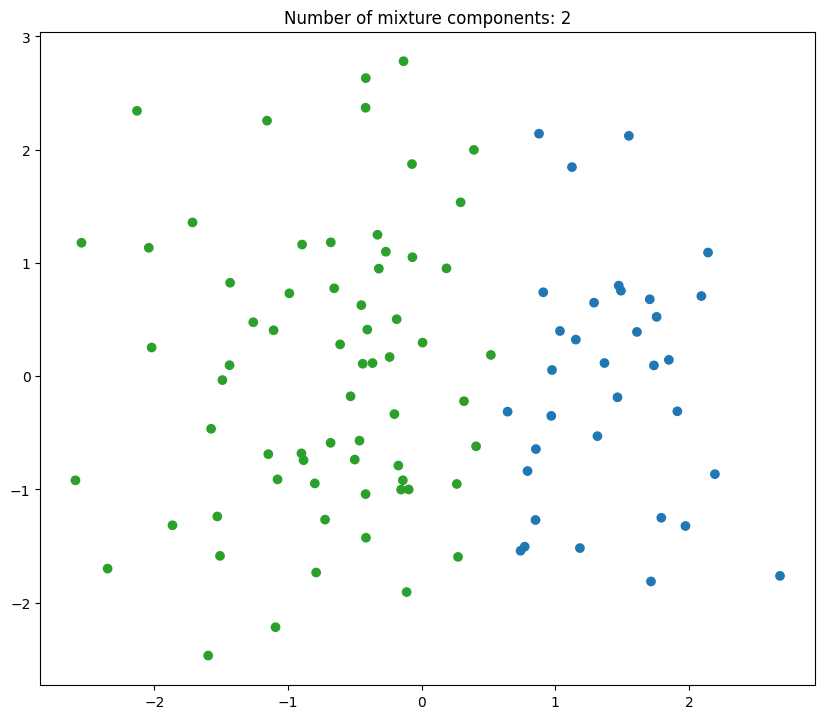

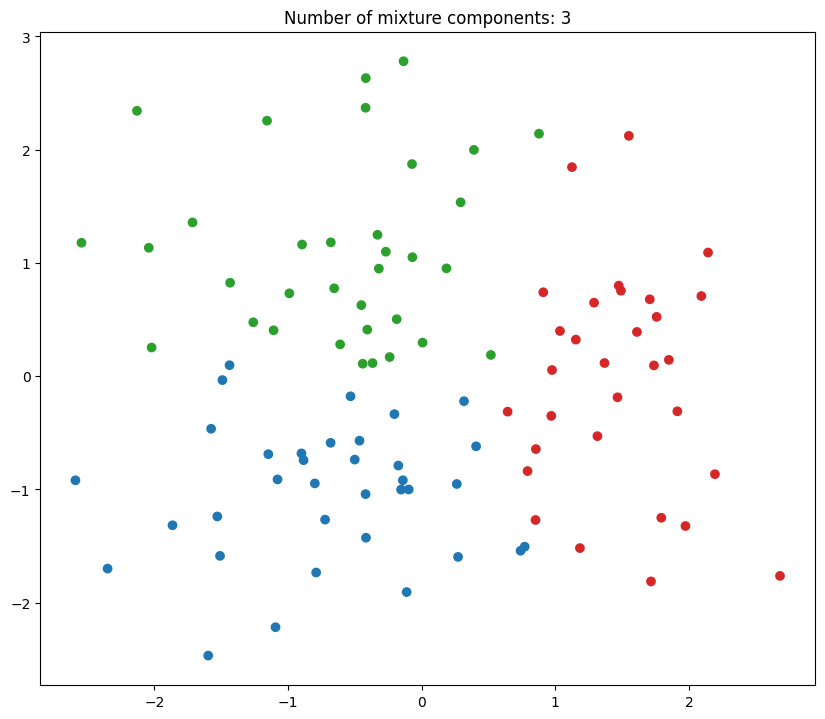

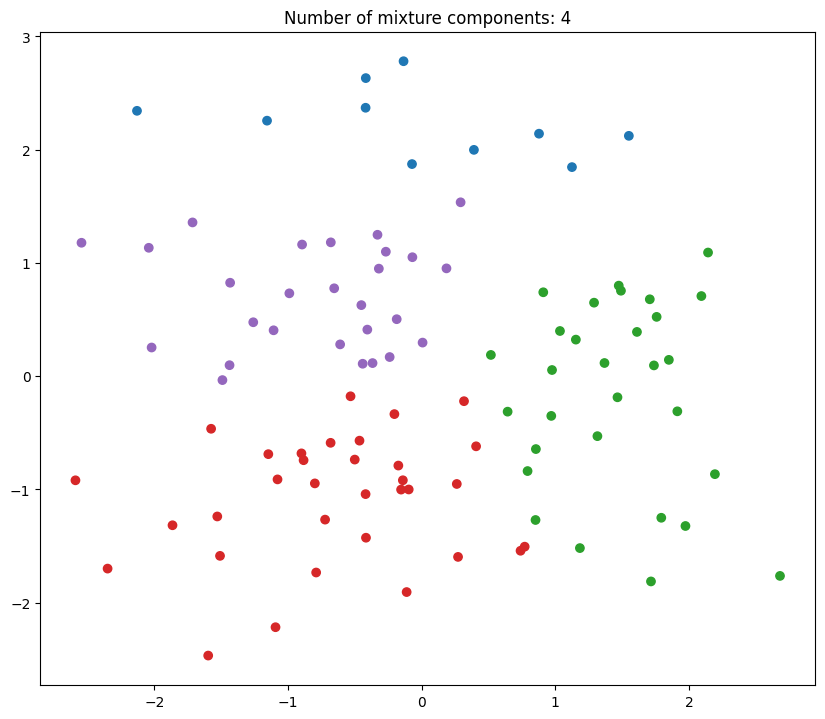

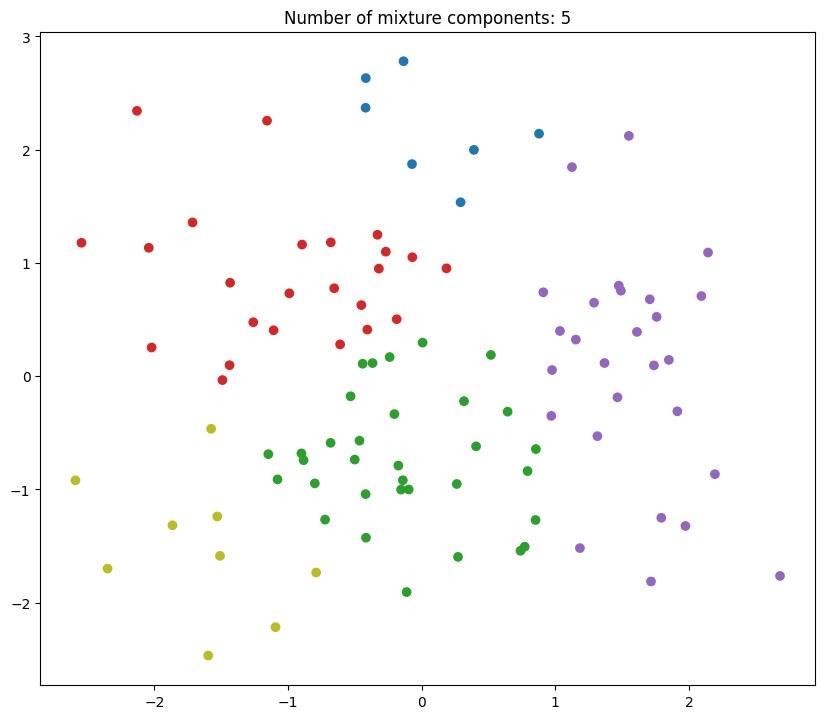

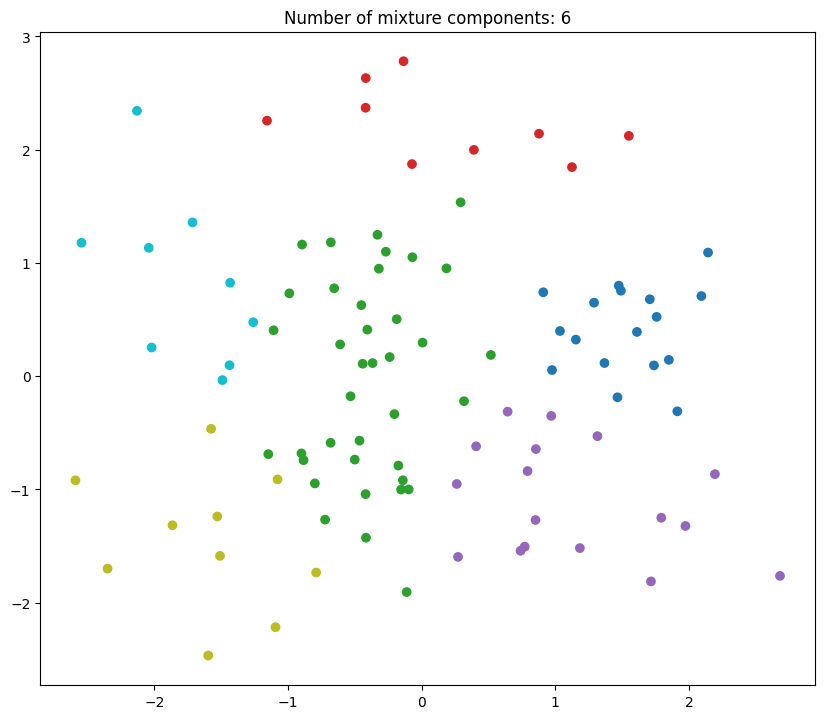

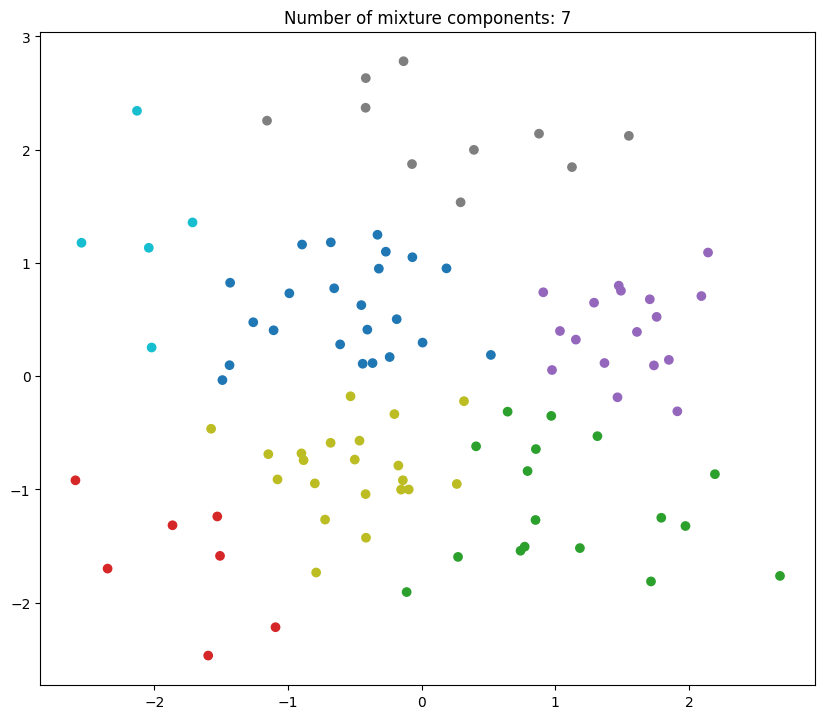

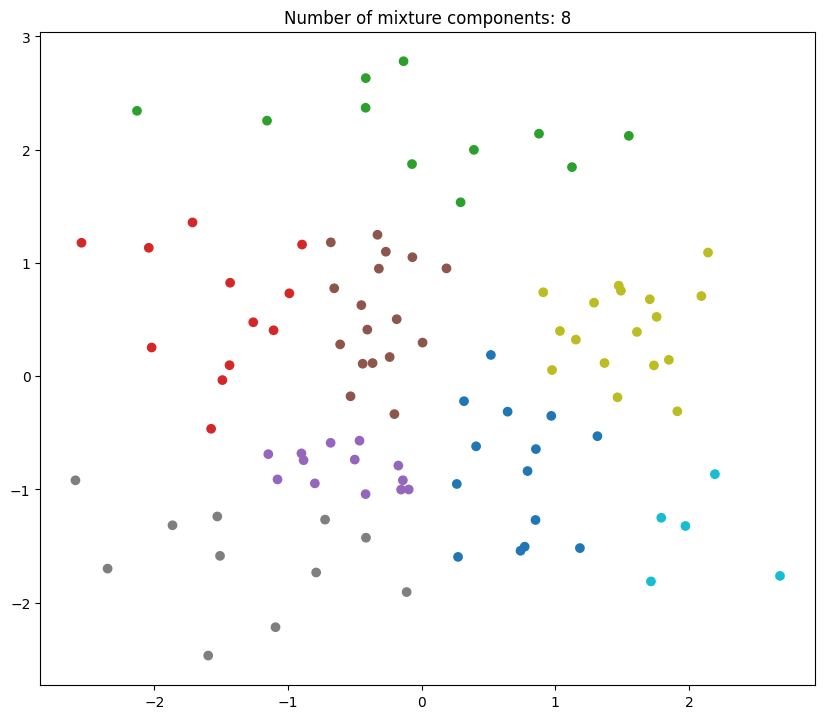

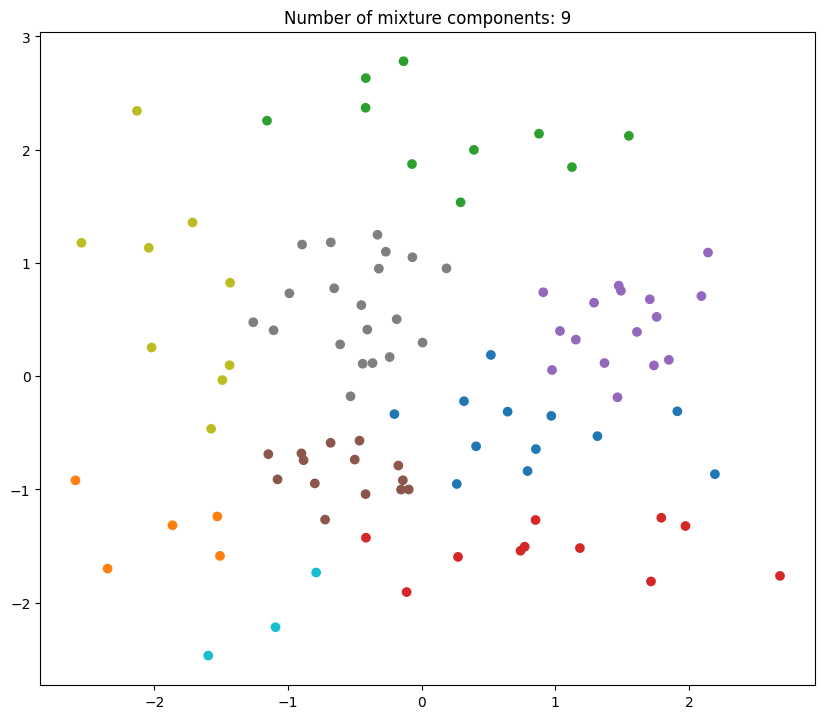

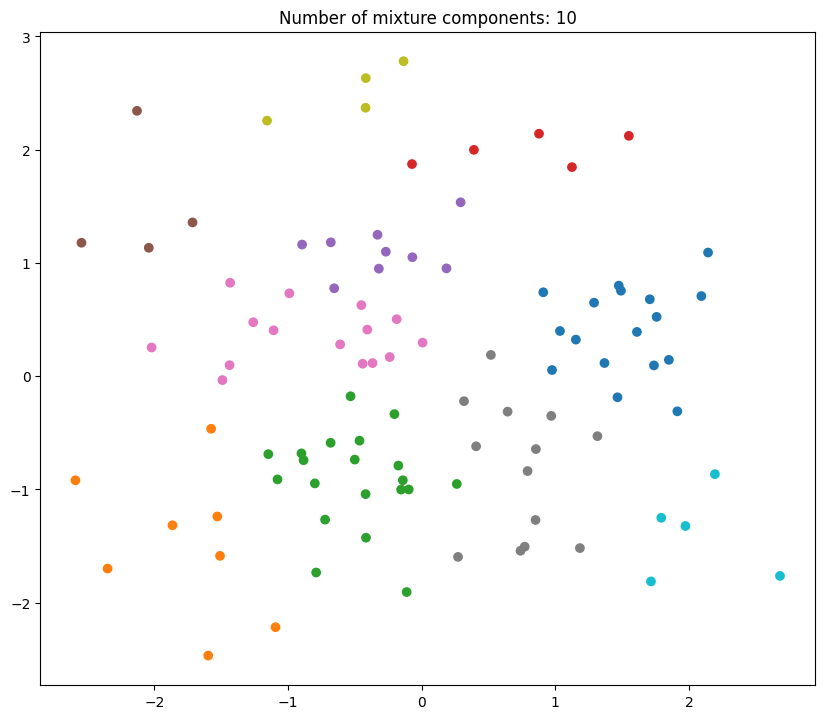

In [ ]:
from sklearn.decomposition import PCA

colors = ['tab:blue', 'tab:green', 'tab:red', 'tab:purple', 'tab:olive', 'tab:cyan', 'tab:grey', 'tab:brown', 'tab:orange', 'tab:pink']
aics = []
bics = []
likelihoods = []

pca = PCA(n_components = 2)
reduced_data = pca.fit_transform(data)

for c in range(2, 11):
  gmm = GaussianMixture(n_components = c, covariance_type='diag')
  gmm.fit(reduced_data)
  predict = gmm.predict(reduced_data)

  log_likelihood = gmm.lower_bound_
  bic = gmm.bic(reduced_data)
  aic = gmm.aic(reduced_data)

  print(f"Log-Likelihood: {log_likelihood}")
  print(f"BIC: {bic}")
  print(f"AIC: {aic}")

  aics.append(aic)
  bics.append(bic)
  likelihoods.append(log_likelihood)

  plt.figure(figsize = (1 * 10, 9 * 10))

  plt.subplot(9, 1, c - 1)
  plt.title(f"Number of mixture components: {c}")
  plt.scatter(reduced_data[:, 0], reduced_data[:, 1], color = [colors[p] for p in predict])

Text(0.5, 0, '# mixture components')

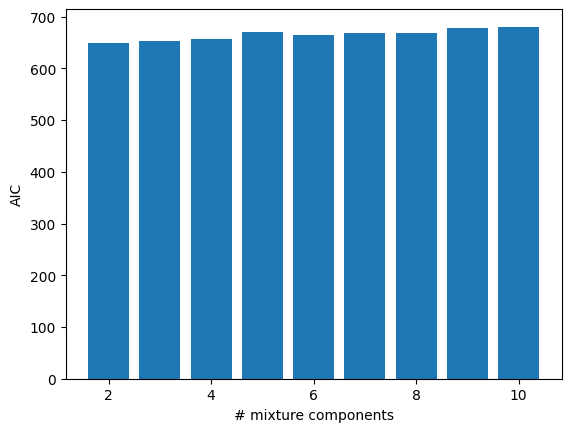

In [ ]:
plt.bar(range(2, 11), aics)
plt.ylabel('AIC')
plt.xlabel('# mixture components')

Text(0.5, 0, '# mixture components')

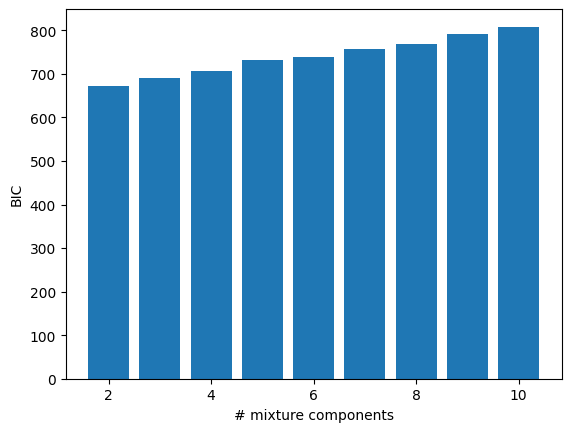

In [ ]:
plt.bar(range(2, 11), bics)
plt.ylabel('BIC')
plt.xlabel('# mixture components')

Text(0.5, 0, '# mixture components')

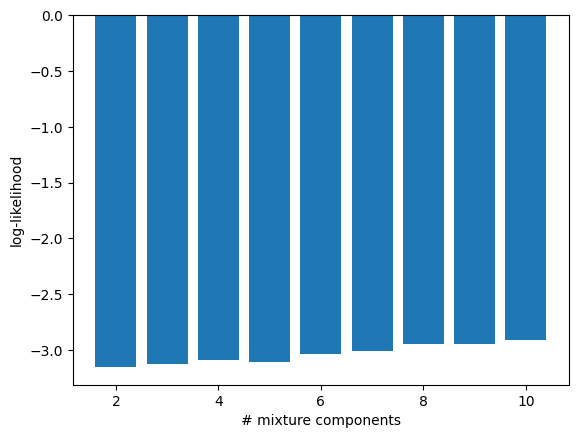

In [ ]:
plt.bar(range(2, 11), likelihoods)
plt.ylabel('log-likelihood')
plt.xlabel('# mixture components')

#### Analysis on reduced data for different number of componnets (TSNE)

Log-Likelihood: -4.834585476209009
BIC: 1008.2460357317619
AIC: 984.7995040578691
Log-Likelihood: -4.803011012407141
BIC: 1025.0061707627578
AIC: 988.5337881589246
Log-Likelihood: -4.777419249569242
BIC: 1042.8371996572778
AIC: 993.3389661235041
Log-Likelihood: -4.744875427939569
BIC: 1059.363788678094
AIC: 996.8397042143797
Log-Likelihood: -4.733826654323153
BIC: 1080.1369217399147
AIC: 1004.5869863462599
Log-Likelihood: -4.70642518766266
BIC: 1097.7428431759315
AIC: 1009.1670568523365
Log-Likelihood: -4.625572547633811
BIC: 1104.62658858212
AIC: 1003.0249513285843
Log-Likelihood: -4.466827462763056
BIC: 1095.9596637774657
AIC: 981.3321755939896
Log-Likelihood: -4.549074869518666
BIC: 1135.3433986605385
AIC: 1007.6900595471219


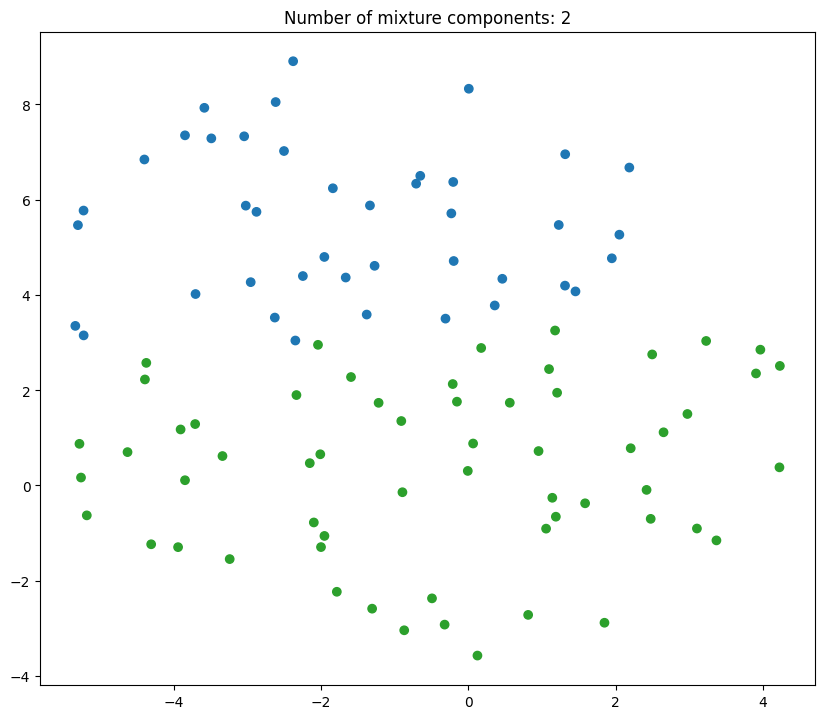

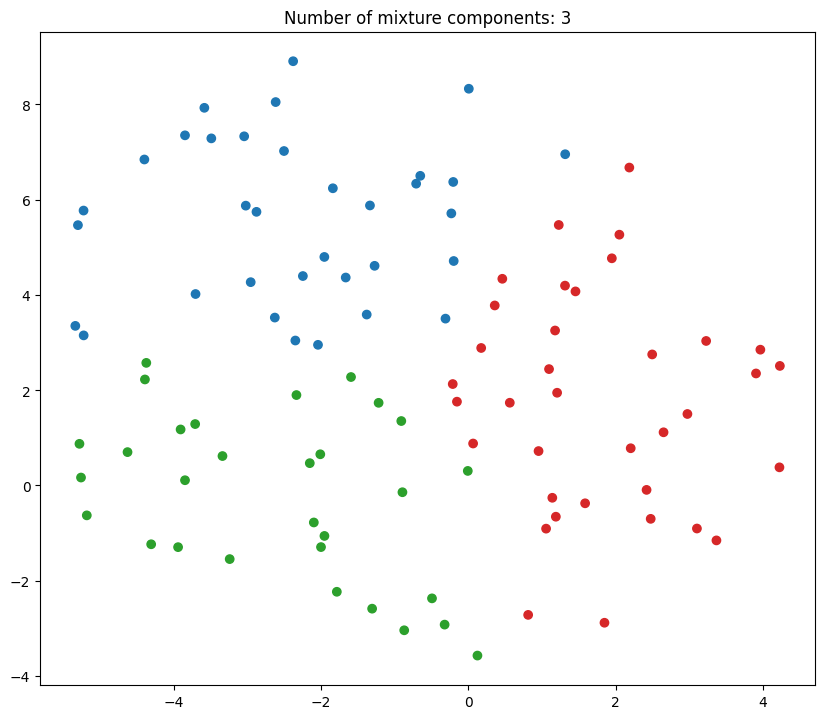

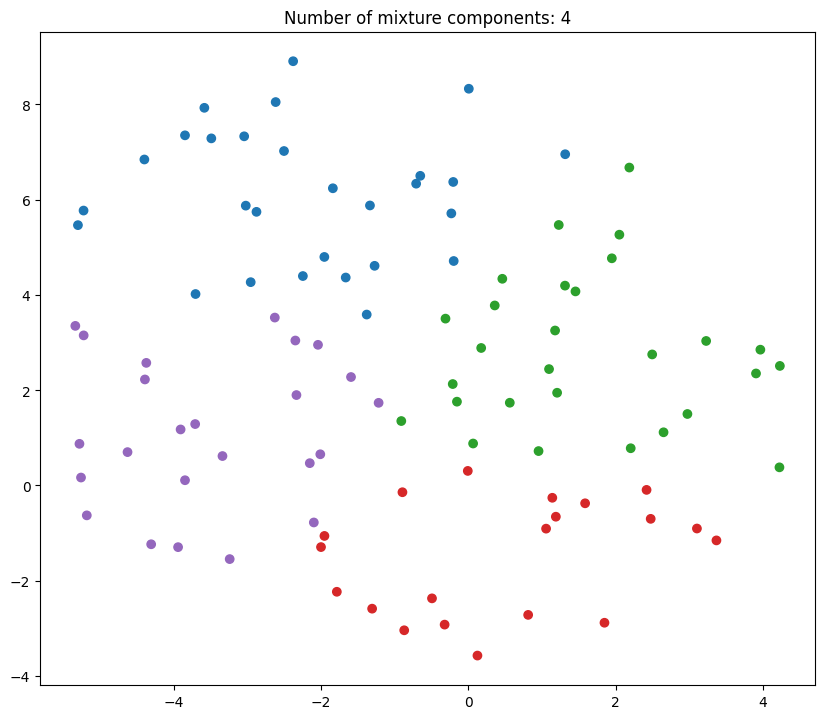

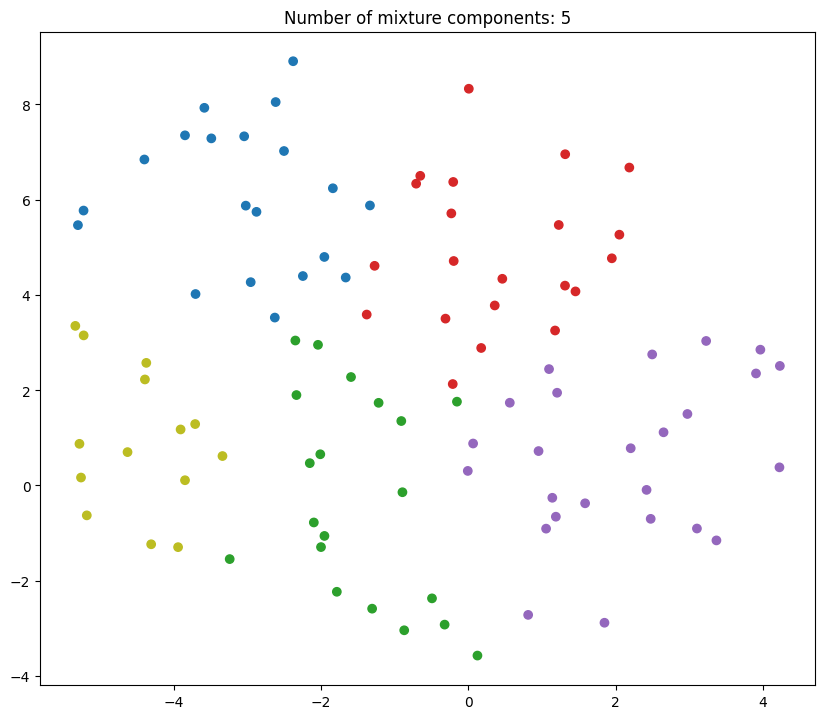

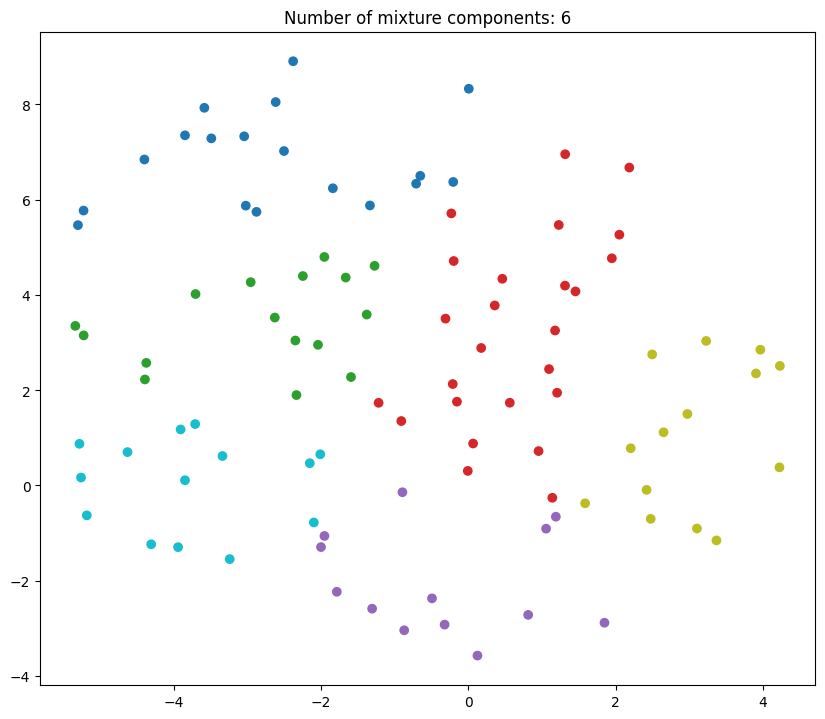

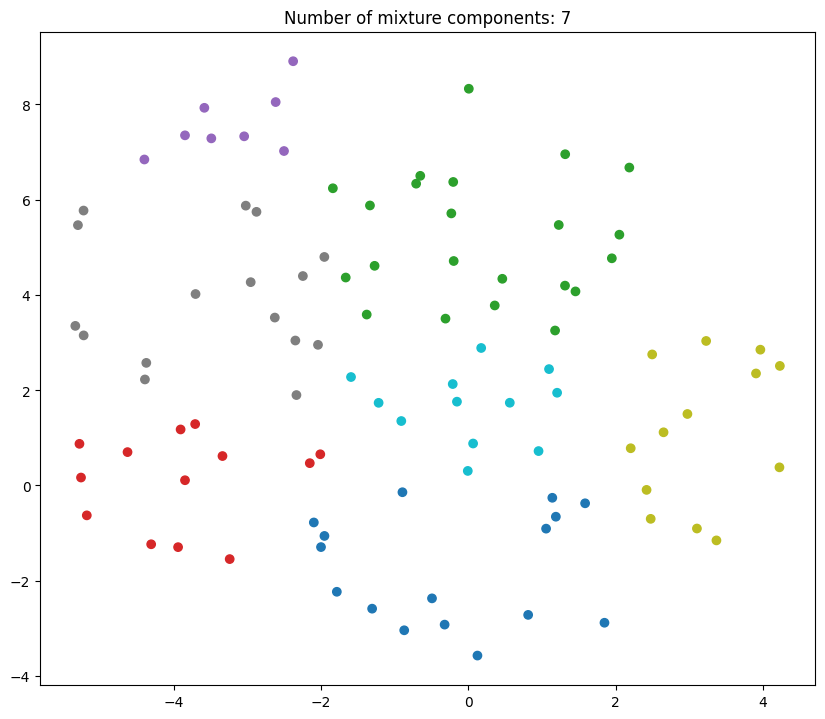

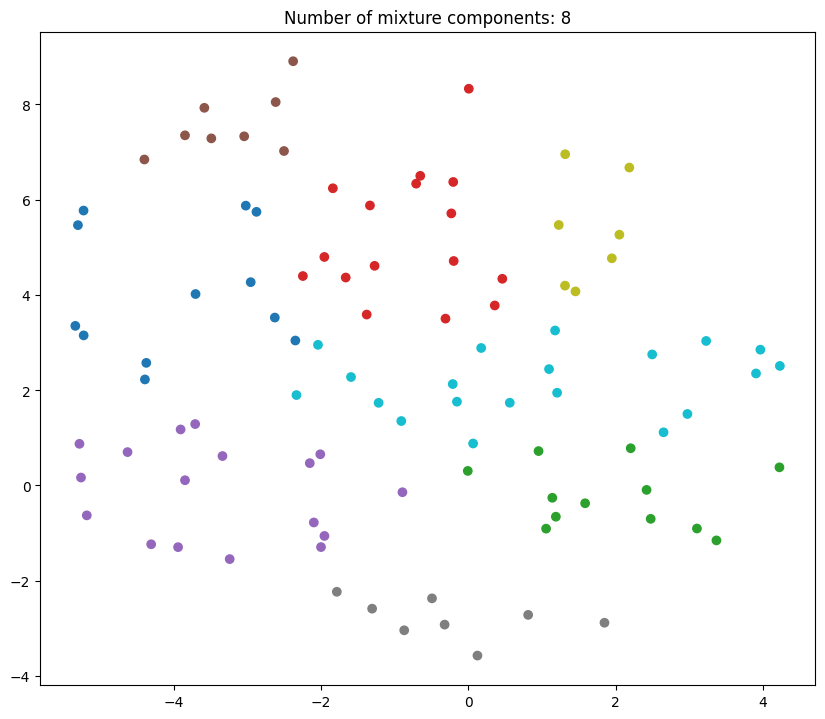

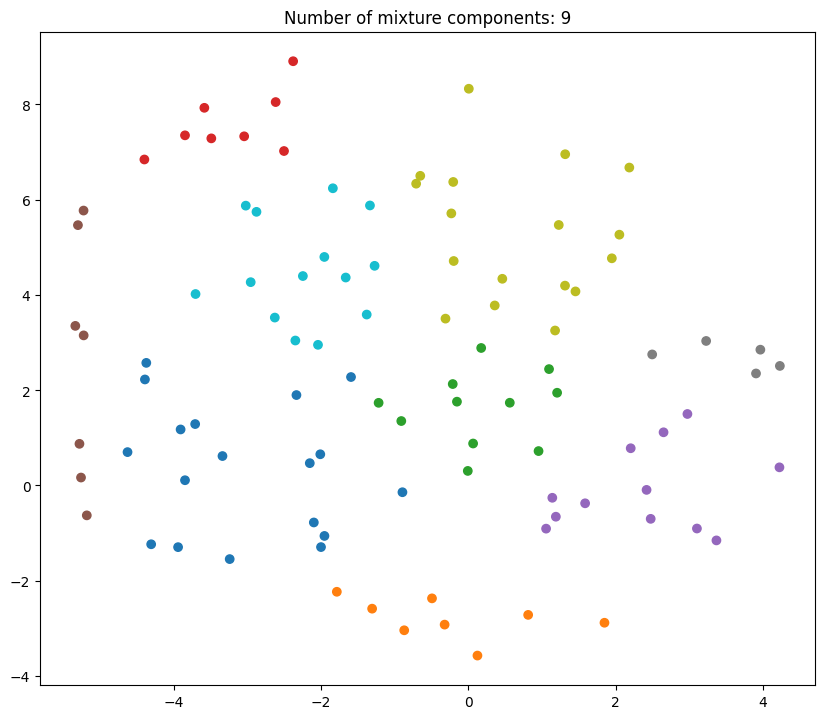

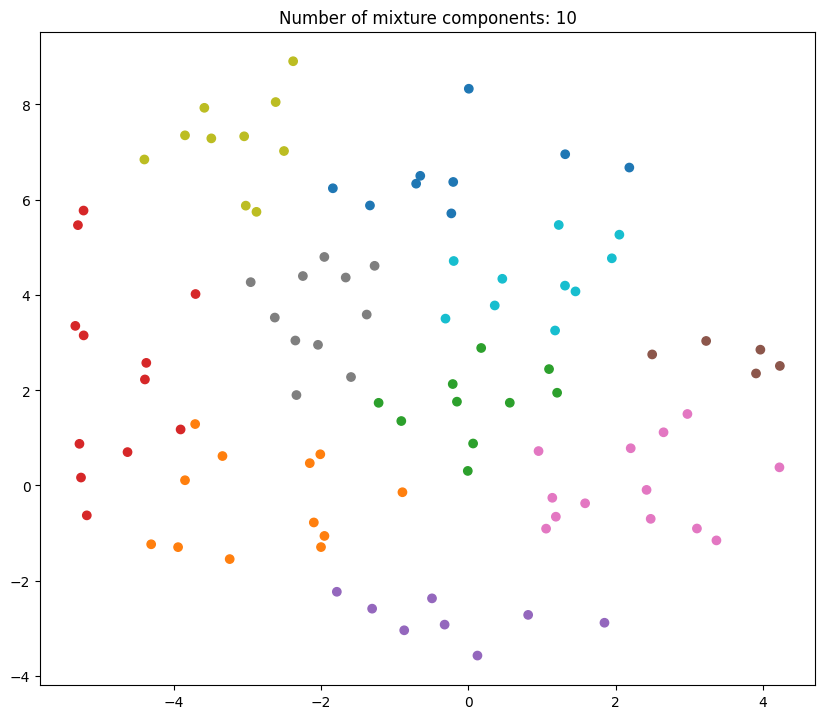

In [ ]:
from sklearn.manifold import TSNE

colors = ['tab:blue', 'tab:green', 'tab:red', 'tab:purple', 'tab:olive', 'tab:cyan', 'tab:grey', 'tab:brown', 'tab:orange', 'tab:pink']
aics = []
bics = []
likelihoods = []

pca = TSNE(n_components = 2)
reduced_data = tsne.fit_transform(data)

for c in range(2, 11):
  gmm = GaussianMixture(n_components = c, covariance_type='diag')
  gmm.fit(reduced_data)
  predict = gmm.predict(reduced_data)

  log_likelihood = gmm.lower_bound_
  bic = gmm.bic(reduced_data)
  aic = gmm.aic(reduced_data)

  print(f"Log-Likelihood: {log_likelihood}")
  print(f"BIC: {bic}")
  print(f"AIC: {aic}")

  aics.append(aic)
  bics.append(bic)
  likelihoods.append(log_likelihood)

  plt.figure(figsize = (1 * 10, 9 * 10))

  plt.subplot(9, 1, c - 1)
  plt.title(f"Number of mixture components: {c}")
  plt.scatter(reduced_data[:, 0], reduced_data[:, 1], color = [colors[p] for p in predict])

Text(0.5, 0, '# mixture components')

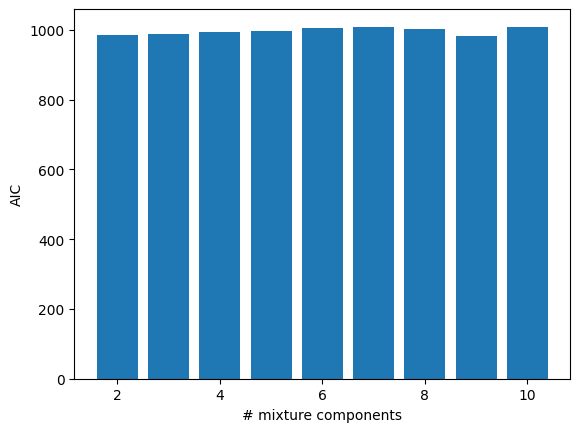

In [ ]:
plt.bar(range(2, 11), aics)
plt.ylabel('AIC')
plt.xlabel('# mixture components')

Text(0.5, 0, '# mixture components')

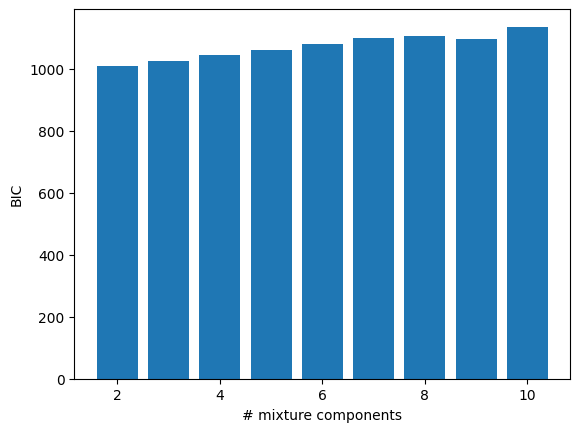

In [ ]:
plt.bar(range(2, 11), bics)
plt.ylabel('BIC')
plt.xlabel('# mixture components')

Text(0.5, 0, '# mixture components')

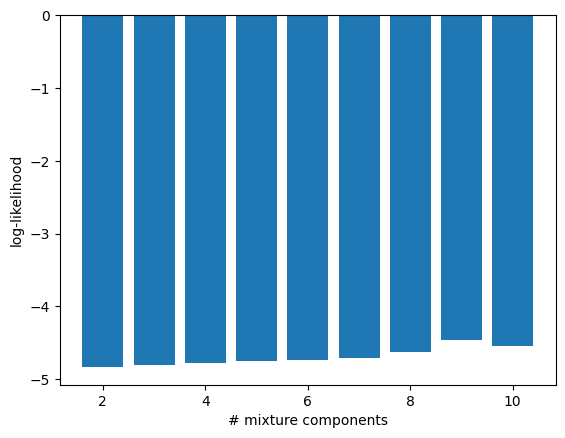

In [ ]:
plt.bar(range(2, 11), likelihoods)
plt.ylabel('log-likelihood')
plt.xlabel('# mixture components')